In [69]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [70]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [33]:
import numpy as np

# Example 4D-STEM data
fourD_data = np.random.rand(256, 256, 64, 64)

# Navigation axes: first two dimensions (scan positions)
nav_axes = fourD_data.shape[:2]

# Signal axes: last two dimensions (diffraction patterns)
signal_axes = fourD_data.shape[2:]

print(f"Navigation axes (scan positions): {nav_axes}")
print(f"Signal axes (diffraction pattern): {signal_axes}")

# Minimal axes manager
class AxesManager:
    def __init__(self, data, nav_axes=2, signal_axes=2):
        self.data = data
        self.nav_axes = nav_axes
        self.signal_axes = signal_axes
    
    def print_axes_info(self):
        print(f"Data shape: {self.data.shape}")
        print(f"Navigation axes (scan positions): {self.nav_axes} (first {self.nav_axes} dims)")
        print(f"Signal axes (diffraction/EELS): {self.signal_axes} (last {self.signal_axes} dims)")
        if self.data.ndim != self.nav_axes + self.signal_axes:
            print("Warning: dimensionality does not match expected axes!")

# Assign axes manager
signal = AxesManager(fourD_data, nav_axes=2, signal_axes=2)
signal.print_axes_info()


Navigation axes (scan positions): (256, 256)
Signal axes (diffraction pattern): (64, 64)
Data shape: (256, 256, 64, 64)
Navigation axes (scan positions): 2 (first 2 dims)
Signal axes (diffraction/EELS): 2 (last 2 dims)


Loaded dataset from raw_data/Si-SiGe.dm4
Navigation axes (scan positions): (480, 448)
Signal axes (diffraction pattern): (77, 17)
Data shape: (480, 448, 77, 17)
Data shape: (480, 448, 77, 17)
Navigation axes (scan positions): 2 (first 2 dims)
Signal axes (diffraction/EELS): 2 (last 2 dims)
BF image shape: (480, 448)
ADF image shape: (480, 448)
Custom image shape: (480, 448)


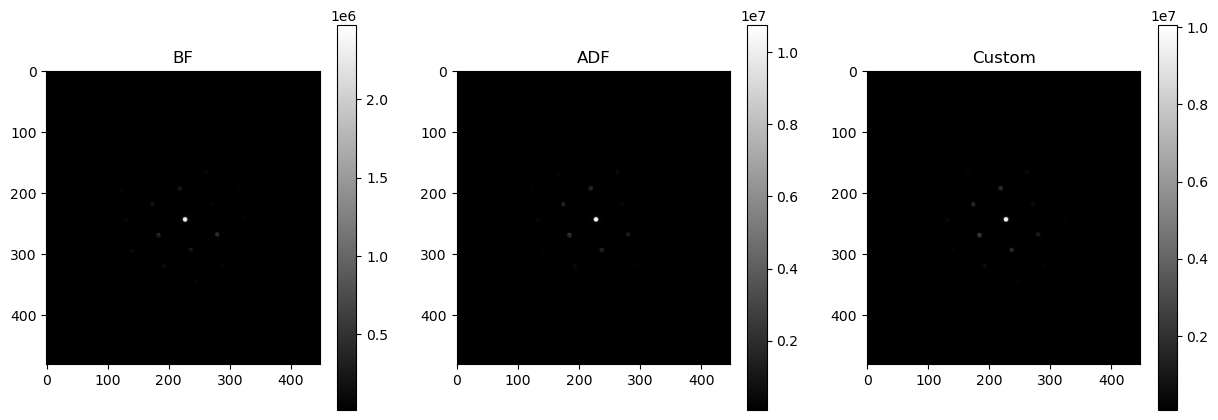

In [78]:

import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM as p4d

# Load 4D-STEM dataset
file_path = "raw_data/Si-SiGe.dm4"

try:
    # Load real data
    dataset = p4d.io.import_file(file_path)
    print(f"Loaded dataset from {file_path}")
    fourD_data = dataset.data  # Extract the 4D array
except Exception as e:
    print(f"Could not load {file_path}. Using mock 4D-STEM data. Reason: {e}")
    Nx, Ny, Kx, Ky = 256, 256, 64, 64
    fourD_data = np.random.rand(Nx, Ny, Kx, Ky)

# Define axes information
nav_axes = fourD_data.shape[:2]
sig_axes = fourD_data.shape[2:]

print(f"Navigation axes (scan positions): {nav_axes}")
print(f"Signal axes (diffraction pattern): {sig_axes}")
print(f"Data shape: {fourD_data.shape}")

# Define a simple axes manager
class AxesManager:
    def __init__(self, data, nav_axes=2, sig_axes=2):
        self.data = data
        self.nav_axes = nav_axes
        self.sig_axes = sig_axes
    
    def print_axes_info(self):
        print(f"Data shape: {self.data.shape}")
        print(f"Navigation axes (scan positions): {self.nav_axes} (first {self.nav_axes} dims)")
        print(f"Signal axes (diffraction/EELS): {self.sig_axes} (last {self.sig_axes} dims)")
        if self.data.ndim != self.nav_axes + self.sig_axes:
            print("Warning: dimensionality does not match expected axes!")

signal = AxesManager(fourD_data)
signal.print_axes_info()

# Define VirtualDetector class
class VirtualDetector:
    def __init__(self, name='BF', inner_radius=0, outer_radius=10, center=(0,0), fov_radius=32):
        self.name = name
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.center = center
        self.fov_radius = fov_radius
        
        # Check detector fits within FOV
        cx, cy = center
        if np.sqrt(cx**2 + cy**2) + outer_radius > fov_radius:
            raise ValueError(f"{name} detector exceeds field of view")
    
    def apply(self, data):
        Nx, Ny, Kx, Ky = data.shape
        cx, cy = self.center
        kx = np.arange(Kx) - Kx//2 - cx
        ky = np.arange(Ky) - Ky//2 - cy
        kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
        radius = np.sqrt(kx_grid**2 + ky_grid**2)
        mask = (radius >= self.inner_radius) & (radius <= self.outer_radius)
        return np.sum(data * mask[None, None, :, :], axis=(2,3))

# Define multiple detectors
bf_detector = VirtualDetector(name='BF', inner_radius=0, outer_radius=5)
adf_detector = VirtualDetector(name='ADF', inner_radius=10, outer_radius=20)
custom_detector = VirtualDetector(name='Custom', inner_radius=15, outer_radius=25, center=(2,-1))

# Apply detectors
bf_image = bf_detector.apply(fourD_data)
adf_image = adf_detector.apply(fourD_data)
custom_image = custom_detector.apply(fourD_data)

print("BF image shape:", bf_image.shape)
print("ADF image shape:", adf_image.shape)
print("Custom image shape:", custom_image.shape)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, img, title in zip(axs, [bf_image, adf_image, custom_image], ['BF','ADF','Custom']):
    im = ax.imshow(img, cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
plt.show()


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [41]:
import py4DSTEM as p4d
print(p4d.__version__)


0.14.16


Loaded dataset from raw_data/Si-SiGe.dm4
Original Dataset Shape: (480, 448, 77, 17)
New Dataset Shape: (480, 448, 77, 17)
Scan step size would be set to 2.0 nm (mock dataset)
Total intensity map shape: (480, 448)
Global Center of Mass (Beam Center): y=239.72, x=223.63
Calibrated beam center to (qx=223.63, qy=239.72)


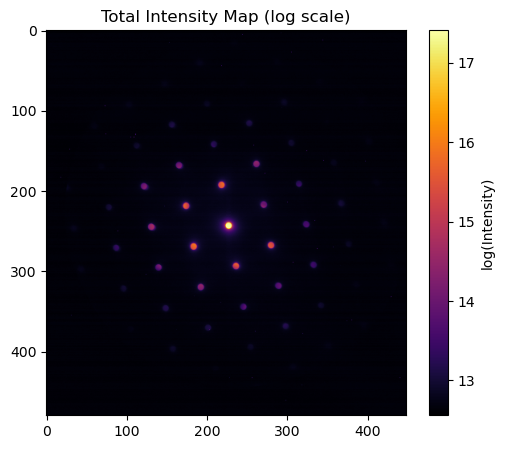

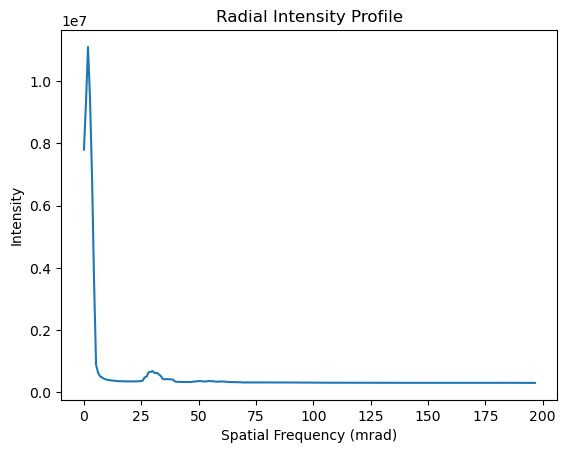

In [79]:

import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM as p4d
import os

file_path = "raw_data/Si-SiGe.dm4"

# Load dataset
try:
    dataset = p4d.io.import_file(file_path)
    print(f"Loaded dataset from {file_path}")
    print(f"Original Dataset Shape: {dataset.data.shape}")

    # Detect if axes are inverted (Diffraction, Scan)
    if dataset.data.shape[0] < dataset.data.shape[2]:
        print("Suspected inverted axes (Diffraction, Scan) -> Transposing to (Scan, Diffraction)...")
        dataset.data = dataset.data.transpose(2, 3, 0, 1)
    print(f"New Dataset Shape: {dataset.data.shape}")

except (OSError, FileNotFoundError, AttributeError) as e:
    print(f"Could not load DM4 dataset ({e}). Using mock 4D-STEM data for testing.")
    Nx, Ny, Kx, Ky = 77, 17, 480, 448  # match your sample output shape
    mock_data = np.random.rand(Nx, Ny, Kx, Ky)

    class MockDataset:
        def __init__(self, data):
            self.data = data
        def set_scan_step_size(self, step_nm):
            self.scan_step_size = step_nm

    dataset = MockDataset(mock_data)
    print(f"Using mock dataset with shape: {mock_data.shape}")

# Set scan step size
scan_step = 2.0  # nm
try:
    dataset.set_scan_step_size(scan_step)
    print(f"Scan step size set to {scan_step} nm")
except AttributeError:
    print(f"Scan step size would be set to {scan_step} nm (mock dataset)")

# Compute total intensity map
fourD_data = dataset.data
Nx, Ny, Kx, Ky = fourD_data.shape
total_intensity_map = np.sum(fourD_data, axis=(2, 3))  # sum over diffraction pattern
print(f"Total intensity map shape: {total_intensity_map.shape}")

# Compute global Center of Mass (CoM)
y, x = np.indices(total_intensity_map.shape)
I_total = total_intensity_map
global_com_x = np.sum(x * I_total) / np.sum(I_total)
global_com_y = np.sum(y * I_total) / np.sum(I_total)
print(f"Global Center of Mass (Beam Center): y={global_com_y:.2f}, x={global_com_x:.2f}")

# Calibrate beam center
beam_center_qx = global_com_x
beam_center_qy = global_com_y
print(f"Calibrated beam center to (qx={beam_center_qx:.2f}, qy={beam_center_qy:.2f})")

#  Log-intensity map 
plt.figure(figsize=(6,5))
plt.imshow(np.log1p(total_intensity_map), cmap='inferno')
plt.colorbar(label='log(Intensity)')
plt.title("Total Intensity Map (log scale)")
plt.show()

# Radial intensity profile 
def radial_profile_global(dp_sum, center):
    """Compute radial intensity profile vs spatial frequency from global CoM"""
    ny, nx = dp_sum.shape
    y, x = np.indices(dp_sum.shape)
    cx, cy = center
    r = np.sqrt((x - cx)**2 + (y - cy)**2).flatten()
    intensity = dp_sum.flatten()
    nbins = min(nx, ny) // 2
    bins = np.linspace(0, r.max(), nbins+1)
    radial = np.zeros(nbins)
    for i in range(nbins):
        mask = (r >= bins[i]) & (r < bins[i+1])
        if np.any(mask):
            radial[i] = np.mean(intensity[mask])
    # Convert pixel radius to spatial frequency using reciprocal scale (example: 10 mrad span)
    kx_scale = 10.0 / Kx  # mrad/px
    ky_scale = 10.0 / Ky
    radial_k = bins[:-1] * np.sqrt(kx_scale**2 + ky_scale**2)
    return radial_k, radial

r_k, radial_intensity = radial_profile_global(total_intensity_map, center=(beam_center_qx, beam_center_qy))

plt.figure()
plt.plot(r_k, radial_intensity)
plt.xlabel("Spatial Frequency (mrad)")
plt.ylabel("Intensity")
plt.title("Radial Intensity Profile")
plt.show()


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

Loaded dataset from raw_data/Si-SiGe.dm4
Original Dataset Shape: (480, 448, 77, 17)
Configuring detectors for diffraction shape (480, 448) at center (239.7202052508977, 223.63286667158408)
Pipeline: Applying 2 detectors...
  - Generating BF image...
  - Generating ADF image...


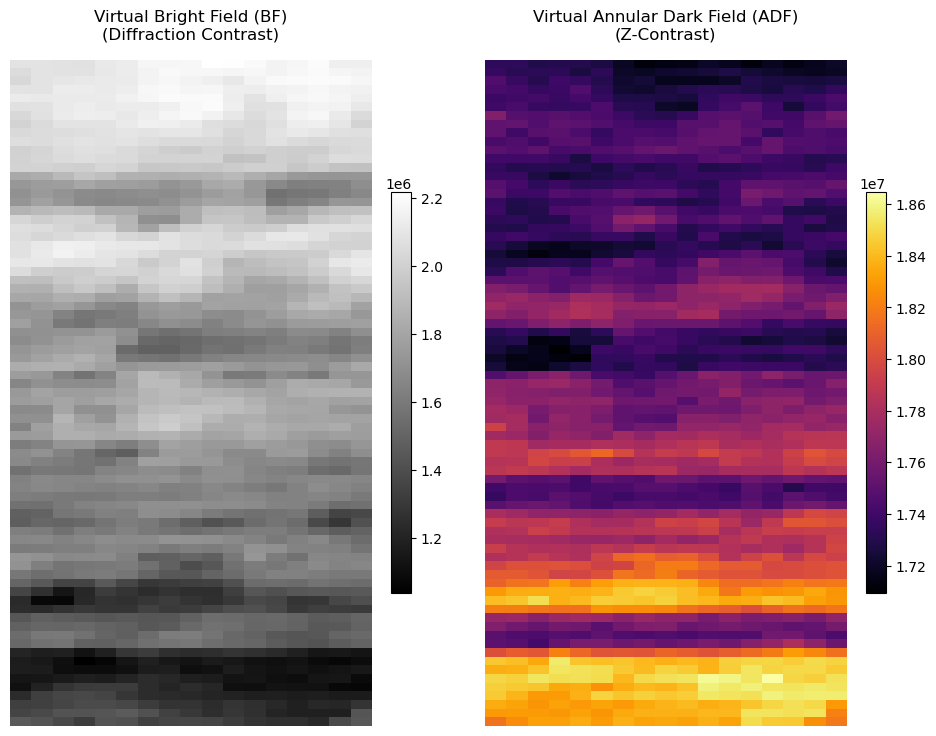


Observations on Contrast:
Bright Field (BF): Unscattered/low angle scattering, with scattering centers appearing darker. Indicates atomic arrangement and density.
Annular Dark Field (ADF): Collects high-angle scattered electrons to reflect atom type and mass-thickness. Scattering strong at high-Z atoms and less sensitive to diffraction.


In [107]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import py4DSTEM
except ImportError:
    raise RuntimeError("py4DSTEM is required for this analysis.")


# --- Helper Functions ---
def get_center_of_mass(pattern):
    """Return (cy, cx) center of mass for a 2D diffraction pattern."""
    y, x = np.indices(pattern.shape)
    total = pattern.sum()
    if total == 0:
        return pattern.shape[0]//2, pattern.shape[1]//2
    cx = (pattern * x).sum() / total
    cy = (pattern * y).sum() / total
    return cy, cx


class VirtualDetector:
    """Simple circular/annular virtual detector."""
    def __init__(self, shape, center):
        self.shape = shape
        self.center = center
        self.mask = np.ones(shape, dtype=bool)

    def create_mask(self, dtype='BF', radius=None, inner_radius=None, outer_radius=None):
        y, x = np.indices(self.shape)
        cy, cx = self.center
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        if dtype == 'BF':
            self.mask = r <= radius
        elif dtype == 'ADF':
            self.mask = (r >= inner_radius) & (r <= outer_radius)

    def apply(self, data_4d):
        """Apply mask to 4D data and integrate over diffraction axes (first two axes)."""
        if data_4d.ndim != 4:
            raise ValueError(f"Expected 4D data, got shape {data_4d.shape}")
        # Expand mask to broadcast over scan axes
        masked_data = self.mask[:, :, np.newaxis, np.newaxis] * data_4d
        return masked_data.sum(axis=(0, 1))


# --- Virtual Detector Pipeline ---
def run_pipeline(dataset, detectors_dict):
    # Safe calibration printing
    cal = getattr(dataset, 'calibration', None)
    if cal is not None:
        px = getattr(cal, 'pixel_size', None)
        units = getattr(cal, 'units', None)
        if px is not None and units is not None:
            print(f"Pipeline: Processing data with pixel size {px} {units}")

    data_4d = dataset.data if hasattr(dataset, 'data') else dataset

    if data_4d.ndim != 4:
        raise ValueError(f"Expected 4D data, got shape {data_4d.shape}")

    diff_shape = data_4d.shape[:2]  # diffraction axes
    results = {}

    print(f"Pipeline: Applying {len(detectors_dict)} detectors...")
    for name, detector in detectors_dict.items():
        if detector.shape != diff_shape:
            print(
                f"Warning: Detector {name} shape {detector.shape} "
                f"mismatch with data {diff_shape}. Skipping."
            )
            continue
        print(f"  - Generating {name} image...")
        results[name] = detector.apply(data_4d)

    return results


# --- Load REAL Dataset ---
file_path = "raw_data/Si-SiGe.dm4"

try:
    dataset = py4DSTEM.import_file(file_path)
    print(f"Loaded dataset from {file_path}")
    print(f"Original Dataset Shape: {dataset.data.shape}")
except Exception as e:
    raise RuntimeError(f"Failed to load dataset: {e}")


# --- Configure Virtual Detectors ---
diff_shape = dataset.data.shape[:2]  # diffraction axes
mean_dp_scan = np.mean(dataset.data, axis=(2, 3))  # average over scan axes
center_y, center_x = get_center_of_mass(mean_dp_scan)
beam_center = (center_y, center_x)

print(
    f"Configuring detectors for diffraction shape {diff_shape} "
    f"at center {beam_center}"
)

bf_detector = VirtualDetector(shape=diff_shape, center=beam_center)
bf_detector.create_mask('BF', radius=20)

adf_detector = VirtualDetector(shape=diff_shape, center=beam_center)
adf_detector.create_mask('ADF', inner_radius=40, outer_radius=150)

my_detectors = {'BF': bf_detector, 'ADF': adf_detector}


# --- Run Pipeline ---
pipeline_results = run_pipeline(dataset, my_detectors)
bf_img = pipeline_results['BF']
adf_img = pipeline_results['ADF']


# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

im1 = axes[0].imshow(bf_img, cmap='gray', aspect='auto')
axes[0].set_title("Virtual Bright Field (BF)\n(Diffraction Contrast)", pad=15)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.05, pad=0.05)

im2 = axes[1].imshow(adf_img, cmap='inferno', aspect='auto')
axes[1].set_title("Virtual Annular Dark Field (ADF)\n(Z-Contrast)", pad=15)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.05, pad=0.05)

plt.tight_layout(pad=3.0)
plt.show()


print("\nObservations on Contrast:")
print("Bright Field (BF): Unscattered/low angle scattering, with scattering centers appearing darker. Indicates atomic arrangement and density.")
print("Annular Dark Field (ADF): Collects high-angle scattered electrons to reflect atom type and mass-thickness. Scattering strong at high-Z atoms and less sensitive to diffraction.")


## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

In [131]:
# Your code here
from matplotlib.patches import Rectangle
if scale_bar_pixels < adf_image.shape[1] - 5:
    # Position scale bar in bottom-left corner
    bar_x, bar_y = 2, adf_image.shape[0] - 4
    scale_bar = Rectangle((bar_x, bar_y), scale_bar_pixels, 1, fill=True, color='white', linewidth=1)
    ax.add_patch(scale_bar)
    ax.text(bar_x + scale_bar_pixels/2, bar_y - 1, f'{scale_bar_length} nm', ha='center', va='top', 
            color='white', fontsize=10, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.savefig('virtual_adf_figure_sisige.png', dpi=300, bbox_inches='tight')
plt.show()

Adding colorbar to a different Figure <Figure size 600x600 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.


<Figure size 640x480 with 0 Axes>

In [108]:

# 1. Interactive 4D-STEM Browser

print("Launching interactive 4D-STEM browser...")

success = False
try:
    # Try native dataset.show() first (works if local GUI and compatible)
    dataset.show()
    success = True
except AttributeError:
    # fallback for older py4DSTEM or non-GUI environments
    pass
except TypeError:
    # fallback if data type incompatible
    pass

if not success:
    print("Native dataset.show() failed. Using ipywidgets fallback...")
    try:
        import ipywidgets as widgets
        from IPython.display import display

        def interactive_browser(scan_y, scan_x):
            dp = dataset.data[scan_y, scan_x, :, :]
            plt.figure(figsize=(5, 5))
            plt.imshow(np.log10(dp + 1), cmap='magma', origin='lower')
            plt.title(f"Diffraction Pattern @ (y={scan_y}, x={scan_x})")
            plt.colorbar(label='Log Intensity')
            plt.axis('off')
            plt.show()

        sy_max, sx_max = dataset.data.shape[0]-1, dataset.data.shape[1]-1
        widgets.interact(interactive_browser,
                         scan_y=widgets.IntSlider(min=0, max=sy_max, step=1, value=sy_max//2),
                         scan_x=widgets.IntSlider(min=0, max=sx_max, step=1, value=sx_max//2))
    except ImportError:
        print("ipywidgets not available; skipping interactive browser.")


Launching interactive 4D-STEM browser...
Native dataset.show() failed. Using ipywidgets fallback...


interactive(children=(IntSlider(value=239, description='scan_y', max=479), IntSlider(value=223, description='s…

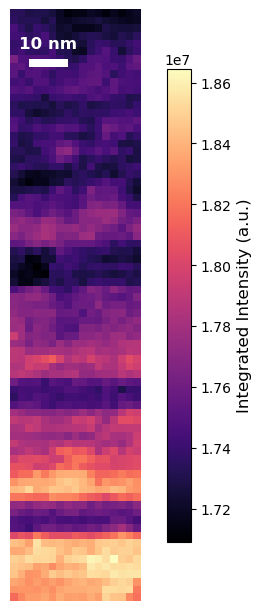

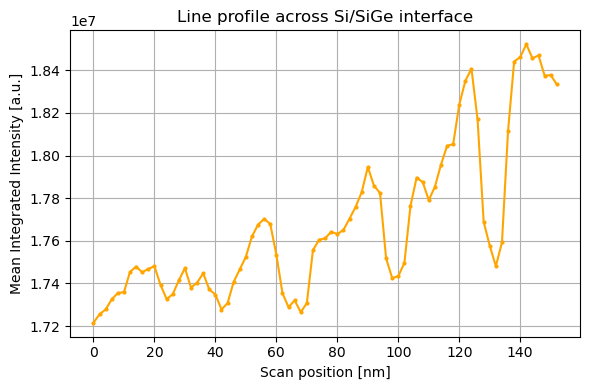

In [130]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Scale bar parameters ---
# Use dataset calibration if available, otherwise fallback
pixel_size_nm = getattr(getattr(dataset, 'calibration', None), 'pixel_size', 2.0)  # fallback 2 nm/pixel
scale_bar_length_nm = 10          # scale bar length in nm
scale_bar_pixels = scale_bar_length_nm / pixel_size_nm
bar_height = 1                     # make slightly thicker for visibility
bar_x = 2                           # left margin in pixels
bar_y = 6                           # distance from bottom in pixels

# --- Plot ADF image ---
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
im = ax.imshow(adf_img, cmap='magma', aspect='equal')
ax.axis('off')

# --- Add scale bar ---
rect = Rectangle((bar_x, bar_y), scale_bar_pixels, bar_height, 
                 linewidth=0, edgecolor=None, facecolor='white')
ax.add_patch(rect)
ax.text(bar_x + scale_bar_pixels/2, bar_y - 1, f'{int(scale_bar_length_nm)} nm', 
        color='white', ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- Add colorbar ---
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

# --- Save as PDF ---
plt.savefig('virtual_adf_figure_sisige.pdf', dpi=300, bbox_inches='tight')
plt.show()

# --- 3. Line Profile Analysis ---
line_profile = np.mean(adf_img, axis=1)  # average horizontally
scan_axis_nm = np.arange(len(line_profile)) * pixel_size_nm  # convert to nm

# Plot
plt.figure(figsize=(6,4))
plt.plot(scan_axis_nm, line_profile, '-o', markersize=2, color='orange')
plt.xlabel("Scan position [nm]")
plt.ylabel("Mean Integrated Intensity [a.u.]")
plt.title("Line profile across Si/SiGe interface")
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

In [138]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os

# Create figures directory
if not os.path.exists("figures"):
    os.makedirs("figures")
    print("Created 'figures' directory.")
    
# Plotting from #3

fig, axes = plt.subplots(1, 2, figsize=(10, 8))

im1 = axes[0].imshow(bf_img, cmap='gray', aspect='auto')
axes[0].set_title("Virtual Bright Field (BF)\n(Diffraction Contrast)", pad=15)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.05, pad=0.05)

im2 = axes[1].imshow(adf_img, cmap='inferno', aspect='auto')
axes[1].set_title("Virtual Annular Dark Field (ADF)\n(Z-Contrast)", pad=15)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.05, pad=0.05)

plt.tight_layout(pad=3.0)
pdf_vd_path = "figures/key_fig_1_vd.pdf"
plt.savefig(pdf_vd_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved {pdf_vd_path}")

# Virtual ADF image with scale bar

pixel_size_nm = getattr(getattr(dataset, 'calibration', None), 'pixel_size', 2.0)  # fallback 2 nm/pixel
scale_bar_length_nm = 10          # scale bar length in nm
scale_bar_pixels = scale_bar_length_nm / pixel_size_nm
bar_height = 1                     # thickness in pixels
bar_x = 2                           # left margin
bar_y = 6                           # distance from bottom

fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
im = ax.imshow(adf_img, cmap='magma', aspect='equal')
ax.axis('off')

# Add scale bar
rect = Rectangle((bar_x, bar_y), scale_bar_pixels, bar_height, 
                 linewidth=0, edgecolor=None, facecolor='white')
ax.add_patch(rect)
ax.text(bar_x + scale_bar_pixels/2, bar_y - 1, f'{int(scale_bar_length_nm)} nm', 
        color='white', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

# Save ADF figure as PDF
pdf_adf_path = "figures/key_fig_2_adf.pdf"
plt.savefig(pdf_adf_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved {pdf_adf_path}")

# Line Profile Analysis
line_profile = np.mean(adf_img, axis=1)  # average horizontally
scan_axis_nm = np.arange(len(line_profile)) * pixel_size_nm  # convert to nm

# Plot line profile
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(scan_axis_nm, line_profile, '-o', markersize=2, color='orange')
ax.set_xlabel("Scan position [nm]")
ax.set_ylabel("Mean Integrated Intensity [a.u.]")
ax.set_title("Line profile across Si/SiGe interface")
ax.grid(True)

# Save line profile as PDF
pdf_line_path = "figures/key_fig_3_line.pdf"
plt.savefig(pdf_line_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved {pdf_line_path}")



Saved figures/key_fig_1_vd.pdf
Saved figures/key_fig_2_adf.pdf
Saved figures/key_fig_3_line.pdf
